<a href="https://colab.research.google.com/github/shuhanmomo/MIT-4.570-Design-Heritage/blob/main/Image%20Segmentation/Tracy_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation using Dense Prediction Transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook is based on the github repo on Dense Prediction Transformers: https://github.com/isl-org/DPT


Install necessary libraries

In [ ]:
!pip install timm # need to run everytime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Connect notebook to Google Drive

In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#change this path to your DPT Segmentation folder
os.chdir('/content/drive/MyDrive/MIT design heritage/W1_Image Segmentation/DPT_Segmentation-20230208T001635Z-001/DPT_Segmentation')

Import necessary libraries

In [ ]:
import os # access to simple file task
import glob
import cv2 # compute vision
import argparse

import torch #pytorch 
import torch.nn.functional as F

import util.io

from torchvision.transforms import Compose
from dpt.models import DPTSegmentationModel # core model imported
from dpt.transforms import Resize, NormalizeImage, PrepareForNet

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir

List all images in 'input' folder

In [ ]:
images = listdir('input') # listing the images in input folder
print(images)# can download jpg images and put into input folder, size less than midium would be good for running time

['Unbroken.jpg', 'Toni.jpg', 'Three Crowns of the Sailor.jpg', 'Time to Hunt.jpg', 'This Must Be the Place.jpg', 'Lawrence of Arabia.jpg', 'Labyrinth of Cinema.jpg', 'Klienten.jpg', 'Knight of Cups.jpg', 'Just Mercy.jpg', 'Laurence Anyways.jpg', 'John and the Hole.jpg', 'Interstellar.jpg', 'Kikujiro.jpg', "Jennifer's Body.jpg", 'Inherent Vice.jpg', 'Hero.jpg', 'Gone to Earth.jpg', 'Honey Boy.jpg', 'Four Times That Night.jpg', 'Immoral Tales.jpg', 'Burning.jpg', 'Blue Ruin.jpg', 'Blue Bayou.jpg', 'Black Is King.jpg', 'Fellini Satyricon.jpg', 'Drive My Car.jpg', 'Ema.jpg', 'Dracula.jpg', 'Destroyer.jpg', 'Cypher.jpg', 'Calmos.jpg', 'Causeway.jpg', 'Deliverance.jpg', 'Chinese Roulette.jpg', 'Beyond the Door II.jpg', 'Aguirre, the Wrath of God.jpg', 'About Time.jpg', 'Amarcord.jpg', 'Arkansas.jpg', 'Anna Karenina.jpg', 'Abandoned.jpg', 'A Zed & Two Noughts.jpg', 'A Wrinkle in Time.jpg', 'Wonder Wheel.jpg', 'A Bay of Blood.jpg', 'View from a Blue Moon.jpg', 'Waves.jpg', 'Utuqaq.jpg', 'Widow

Create empty dataframe of images and visual feature scores

In [ ]:
images_df = pd.DataFrame(images)# create one-column pd dataframe
images_df.columns = ['filename']
images_df.head()

,filename
0,Unbroken.jpg
1,Toni.jpg
2,Three Crowns of the Sailor.jpg
3,Time to Hunt.jpg
4,This Must Be the Place.jpg


In [ ]:
# list of labels which the model try to identify, ade20k classes
labels = ['wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed', 'window', 'grass', 'cabinet', 'sidewalk', 'person', 'earth', 'door', 'table', 'mountain', 'plant', 'curtain', 'chair', 'car', 'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug', 'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe', 'lamp', 'bathtub', 'railing', 'cushion', 'base', 'box', 'column', 'signboard', 'dresser', 'counter', 'sand', 'sink', 'skyscraper', 'fireplace', 'refrigerator', 'grandstand', 'path', 'stairs', 'runway', 'case', 'pooltable', 'pillow', 'screen', 'stairway', 'river', 'bridge', 'bookcase', 'blind', 'coffeetable', 'toilet', 'flower', 'book', 'hill', 'bench', 'countertop', 'stove', 'palmtree', 'kitchen', 'computer', 'swivelchair', 'boat', 'bar', 'arcade', 'hut', 'bus', 'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 'streetlight', 'booth', 'television', 'airplane', 'dirttrack', 'apparel', 'pole', 'land', 'balustrade', 'escalator', 'ottoman', 'bottle', 'sideboard', 'poster', 'stage', 'van', 'ship', 'fountain', 'conveyerbelt', 'canopy', 'washer', 'toy', 'pool', 'stool', 'barrel', 'basket', 'waterfall', 'tent', 'bag', 'motorbike', 'cradle', 'oven', 'ball', 'food', 'step', 'tank', 'brandname', 'microwave', 'pot', 'animal', 'bicycle', 'lake', 'dishwasher', 'screen', 'blanket', 'sculpture', 'hood', 'sconce', 'vase', 'trafficlight', 'tray', 'trashcan', 'fan', 'pier', 'crtscreen', 'plate', 'monitor', 'bulletinboard', 'shower', 'radiator', 'glass', 'clock', 'flag']

In [ ]:
for i in range(0,150):# will populate the picture has how much probability belonging to one class
    images_df[labels[i]] = 0

images_df.head()

<ipython-input-48-56b4a2899629>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  images_df[labels[i]] = 0


,filename,wall,building,sky,floor,tree,ceiling,road,bed,window,...,pier,crtscreen,plate,monitor,bulletinboard,shower,radiator,glass,clock,flag
0,Unbroken.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Toni.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Three Crowns of the Sailor.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Time to Hunt.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,This Must Be the Place.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Initialize the DPT model for prediction

In [ ]:
model_path = "weights/dpt_hybrid-ade20k-53898607.pt"
model_type = 'dpt_hybrid' # use ade20k model set, we use hybrid segmentation one 
optimize = True

In [ ]:
#INITIALIZE MODEL - This may take a while. 
"""Run segmentation network

Args:
    input_path (str): path to input folder
    output_path (str): path to output folder
    model_path (str): path to saved model
"""
print("initialize")

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" % device)

net_w = net_h = 480

# load network
if model_type == "dpt_large":
    model = DPTSegmentationModel(
        150,
        path=model_path,
        backbone="vitl16_384",
    )
elif model_type == "dpt_hybrid":
    model = DPTSegmentationModel(
        150,
        path=model_path,
        backbone="vitb_rn50_384",
    )
else:
    assert (
        False
    ), f"model_type '{model_type}' not implemented, use: --model_type [dpt_large|dpt_hybrid]"

transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        PrepareForNet(),
    ]
)

model.eval()

if optimize == True and device == torch.device("cuda"):
    model = model.to(memory_format=torch.channels_last)
    model = model.half()

model.to(device)

initialize
device: cuda


DPTSegmentationModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): 

Loop through the dataframe and populate the feature scores by running the DPT model on each file. 

In [ ]:
input_path = "input"
output_path = "output"
savename = "images_scores.csv"

In [ ]:
start_index = 0 
for i in range(start_index,len(images_df)):
    print("Processing file "+str(i+1)+"/"+str(len(images_df)))
    
    filename = images_df.iloc[i]['filename']#look for filename
    img_name = input_path+'/'+filename #concanate
    print(img_name)

    # input
    img = util.io.read_image(img_name)
    img_input = transform({"image": img})["image"]

    # compute
    with torch.no_grad():
        sample = torch.from_numpy(img_input).to(device).unsqueeze(0)
        if optimize == True and device == torch.device("cuda"):
            sample = sample.to(memory_format=torch.channels_last)
            sample = sample.half()

        out = model.forward(sample) #store the result of prediction

        prediction = torch.nn.functional.interpolate(
            out, size=img.shape[:2], mode="bicubic", align_corners=False
        )
        prediction = torch.argmax(prediction, dim=1) + 1
        prediction = prediction.squeeze().cpu().numpy() #sort all detection and out most possible one
        
        for j in range(1,151):
          # populate one column by one in the dataframe
            score = prediction[prediction == j].size/prediction.size
            images_df[labels[j-1]].iloc[i] = score
    
    #save file after every 50 images        
    if(i%50) == 0:
        images_df.to_csv(output_path+'/'+savename)
        print("File_Saved")
            
    # save segmentation output image in output folder
    filepath = os.path.join(output_path, os.path.splitext(os.path.basename(img_name))[0])
    util.io.write_segm_img(filepath, img, prediction, alpha=1)

images_df.to_csv(output_path+'/'+savename)
print("File_Saved")
print("finished")  

Processing file 1/103
input/Unbroken.jpg


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


File_Saved
Processing file 2/103
input/Toni.jpg
Processing file 3/103
input/Three Crowns of the Sailor.jpg
Processing file 4/103
input/Time to Hunt.jpg
Processing file 5/103
input/This Must Be the Place.jpg
Processing file 6/103
input/Lawrence of Arabia.jpg
Processing file 7/103
input/Labyrinth of Cinema.jpg
Processing file 8/103
input/Klienten.jpg
Processing file 9/103
input/Knight of Cups.jpg
Processing file 10/103
input/Just Mercy.jpg
Processing file 11/103
input/Laurence Anyways.jpg
Processing file 12/103
input/John and the Hole.jpg
Processing file 13/103
input/Interstellar.jpg
Processing file 14/103
input/Kikujiro.jpg
Processing file 15/103
input/Jennifer's Body.jpg
Processing file 16/103
input/Inherent Vice.jpg
Processing file 17/103
input/Hero.jpg
Processing file 18/103
input/Gone to Earth.jpg
Processing file 19/103
input/Honey Boy.jpg
Processing file 20/103
input/Four Times That Night.jpg
Processing file 21/103
input/Immoral Tales.jpg
Processing file 22/103
input/Burning.jpg
Pr

Test the csv result


(array([82.,  3.,  2.,  4.,  4.,  1.,  2.,  1.,  2.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

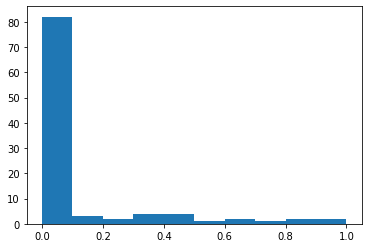

In [ ]:
images_df.head()
plt.hist(images_df['water'])